# Classification extraction

Will load images, then classify them using previous developed CNN

In [18]:
import torch
from torchvision import models
from torchvision import transforms
import numpy as np
from pathlib import Path
from tqdm import tqdm
import cv2
import random
from PIL import Image
import time

## Code variable

In [6]:
CNN_weight = Path('./CNN_weight/SqueezeNet_pretrain_epoch-38.pt')
images_raw = Path('D:/Data/ELO_images_jpg_crop_5CNN')
save_image_path = Path('wrong classification extraction')
data_npy = False

## CNN

### AlexNet

In [3]:
Net = models.alexnet(pretrained=True)
num_ftrs = Net.classifier[6].in_features
Net.classifier[6] = torch.nn.Linear(num_ftrs,3)

### SqueezeNet

In [5]:
Net = models.squeezenet1_0(pretrained=True)
Net.classifier[1] = torch.nn.Conv2d(512, 3, kernel_size=(1,1), stride=(1,1))

### Load trained weight in the CNN

In [6]:
Net.load_state_dict(torch.load(CNN_weight))

<All keys matched successfully>

## Cleaning work directory

In [7]:
image_removed = 0
for file in tqdm(save_image_path.glob('**/*.jpg')): #extract every jpg in the folder
    try:
        #print(file)
        file.unlink() # remove the image
        image_removed += 1
    except Exception as e:
        print(e)
print(f"{image_removed} has been deleted")

0it [00:00, ?it/s]

0 has been deleted


## Data preprocessing

In [8]:
class data_ELO():
    IMG_SIZE = 224
    NORMAL = Path(r'D:\Data\ELO_images_jpg_crop_5CNN\0')
    POROUS = Path(r'D:\Data\ELO_images_jpg_crop_5CNN\1')
    BULGING = Path(r'D:\Data\ELO_images_jpg_crop_5CNN\2')
    LABELS = {NORMAL:0, POROUS:1,BULGING:2}
    
    data= []
    
    normal_count = 0
    porous_count = 0
    bulging_count = 0
    
    error_count = 0
    total_image = 0
    
    
    
    def make_preprocess_data(self):
        for label in self.LABELS:
            for file in tqdm(label.glob('*.jpg')): #extract every jpg in the folder
                try:
                    img = cv2.imread( str(file), cv2.IMREAD_COLOR)
                    img = cv2.resize(img , (self.IMG_SIZE, self.IMG_SIZE))
                    self.data.append([np.array(img) / 255, np.eye(3)[self.LABELS[label]] ])
                    self.normal_count , self.porous_count, self.bulging_count = [self.normal_count , self.porous_count, self.bulging_count] +  np.eye(3)[self.LABELS[label]]
                    self.total_image += 1
                except Exception as e:
                    self.error_count +=1
                    print(e)
                    
                #if self.total_image > 1000:
                #    break
                    
        random.shuffle(self.data)
        print(f"Importation error : {self.error_count}")
        print(f"Data repartition: Normal {self.normal_count} ; Porous {self.porous_count} ; bulging_count {self.bulging_count} ; Total {self.total_image}")
        print(f"Data repartition: Normal {self.normal_count/self.total_image} % ; Porous {self.porous_count/ self.total_image} % ; bulging_count {self.bulging_count/ self.total_image}%")
    
    def save_data(self,name='data'):
        np.save( name , self.data , allow_pickle = True)
        print(f"Data saved in {name}.npy") 
        data = []
        print('Data cleared')
        
    def load_data(self,name='data'):
        self.data = np.load(name + '.npy', allow_pickle = True )

In [11]:
data = data_ELO()
if data_npy:
    data.load_data()
else:
    data.make_preprocess_data()
    #data.save_data()
    

3167it [00:19, 164.60it/s]
3167it [00:20, 157.88it/s]
3167it [00:18, 167.56it/s]


Importation error : 0
Data repartition: Normal 3167.0 ; Porous 3167.0 ; bulging_count 3167.0 ; Total 9501
Data repartition: Normal 0.3333333333333333 % ; Porous 0.3333333333333333 % ; bulging_count 0.3333333333333333%


# CNN processing

In [12]:
Net.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
Net.to(device)

Running on the GPU


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
total_true = 0
total_false = 0
confusion_matrix = np.zeros((3,3))

transform_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
start_time = time.time()
for i in tqdm( range(0, 100)): #len(data.data) ) ):
    X,y = data.data[i]
    X = (X ).astype(np.float)
    X = transform_img(X)
    X = X.view(1, -1 , 224, 224)
    X = X.to(device, dtype=torch.float)
    y_pred = Net(X).to(device)
    y_pred_class = torch.argmax(y_pred)
   
    y = torch.argmax(torch.Tensor(y)) 


print("--- %s seconds ---" % ((time.time() - start_time  )/100))

100%|██████████| 100/100 [00:00<00:00, 182.43it/s]

--- 0.00554664134979248 seconds ---


In [15]:
confusion_matrix.astype(np.int)

array([[2832,  122,   76],
       [  51, 3016,   12],
       [ 284,   29, 3079]])

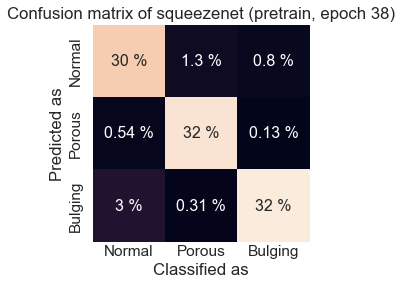

In [16]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.set(font_scale=1.4) # for label size
x_axis_labels = ['Normal','Porous','Bulging']
y_axis_labels =  ['Normal','Porous','Bulging']
confusion_matrix = sn.heatmap(confusion_matrix_per, annot=True, annot_kws={"size": 16}, square = True,cbar=False )
confusion_matrix.set_xticklabels(x_axis_labels,va= "center")
confusion_matrix.set_yticklabels(y_axis_labels,va= "center")
for t in confusion_matrix.texts: t.set_text(t.get_text() + " %") # add % to every text value
confusion_matrix.set(title="Confusion matrix of squeezenet (pretrain, epoch 38)",
      xlabel="Classified as",
      ylabel="Predicted as",)
figure = confusion_matrix.get_figure()
figure.savefig(str(save_image_path.joinpath("confusion_matrix.png")), bbox_inches='tight')